# Exploratory Data Analysis

In [1]:
import os
from io import BytesIO, StringIO
from pathlib import Path

import boto3
import botocore.exceptions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
import seaborn as sns

In [2]:
PROJ_ROOT = Path.cwd().parent

In [3]:
assert load_dotenv(dotenv_path=PROJ_ROOT.parent / '.env')

## About

Exploratory data analysis on the training data.

## User Inputs

In [4]:
# R2 data bucket details
bucket_name = 'cc-churn-splits'
# # name of train data key (file) in private R2 bucket
r2_key_train = 'train_data.parquet.gzip'

In [5]:
models_dir = PROJ_ROOT / 'models'
figures_dir = models_dir / 'figures'

account_id = os.getenv('ACCOUNT_ID')
access_key_id = os.getenv('ACCESS_KEY_ID_USER2')
secret_access_key = os.getenv('SECRET_ACCESS_KEY_USER2')

s3_client = boto3.client(
    's3',
    endpoint_url=f'https://{account_id}.r2.cloudflarestorage.com',
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    region_name='auto'
)

In [6]:
def pandas_read_parquet_r2(bucket_name, r2_key):
    """Read parquet file from private R2 bucket."""
    s3_object = s3_client.get_object(Bucket=bucket_name, Key=r2_key)
    df = pd.read_parquet(
        BytesIO(s3_object['Body'].read()), dtype_backend='pyarrow'
    )
    return df


def save_fig(fig, fig_dir, name):
    fig.savefig(f"{fig_dir}/{name}.png", dpi=144, bbox_inches="tight")

## Load Data

Load the training data

In [7]:
%%time
df_clean = (
    pandas_read_parquet_r2(bucket_name, r2_key_train)
    .astype(
        {
            "gender": 'string[pyarrow]',
            "marital_status": 'string[pyarrow]',
            "income_category": 'string[pyarrow]',
            "card_category": 'string[pyarrow]',
        }
    )
)
with pd.option_context('display.max_columns', None):
    display(df_clean)

,clientnum,is_churned,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,num_products,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolv_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,710115108,0,45,F,2,Graduate,Unknown,$40K - $60K,Blue,37,5,2,3,5562.0,1556.0,4006.0,0.751,4568.0,76,0.767,0.28
1,713668158,1,31,F,1,Uneducated,Single,Unknown,Blue,36,2,3,3,21067.0,0.0,21067.0,0.995,9212.0,71,0.821,0.0
2,710180958,0,43,M,3,High School,Single,$40K - $60K,Blue,33,5,2,3,3040.0,2517.0,523.0,0.493,1598.0,31,0.476,0.828
3,711204483,1,56,M,4,High School,Married,$60K - $80K,Blue,46,3,3,3,2340.0,1930.0,410.0,0.987,781.0,15,0.364,0.825
4,712797258,0,43,M,3,Graduate,Married,$120K +,Blue,33,3,1,3,34516.0,2129.0,32387.0,0.587,1463.0,38,0.583,0.062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6977,710844408,0,38,M,3,Post-Graduate,Married,$60K - $80K,Blue,36,4,3,2,2584.0,0.0,2584.0,0.593,1843.0,28,0.647,0.0
6978,711994458,0,47,F,4,High School,Married,Unknown,Blue,39,6,4,0,1537.0,0.0,1537.0,0.712,4234.0,75,0.786,0.0
6979,712914783,0,43,M,5,Graduate,Single,$40K - $60K,Blue,31,4,1,2,7564.0,0.0,7564.0,0.61,4743.0,82,0.822,0.0
6980,719694408,1,30,F,1,College,Single,Less than $40K,Blue,36,4,3,6,4541.0,0.0,4541.0,0.976,7996.0,80,0.778,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6982 entries, 0 to 6981
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype                                                      
---  ------                  --------------  -----                                                      
 0   clientnum               6982 non-null   int32[pyarrow]                                             
 1   is_churned              6982 non-null   int8[pyarrow]                                              
 2   customer_age            6982 non-null   int8[pyarrow]                                              
 3   gender                  6982 non-null   string                                                     
 4   dependent_count         6982 non-null   int8[pyarrow]                                              
 5   education_level         6982 non-null   dictionary<values=string, indices=int8, ordered=0>[pyarrow]
 6   marital_status          6982 non-null   string  

## Clean Data

### Handling Missing or Unknown Values

Several categorical columns, like Education_Level, Marital_Status, and Income_Category, contained the value "Unknown". This is a placeholder for missing or unavailable data. We replaced these with NaN to treat them as missing values properly. This allows us to later apply imputation techniques to fill them in appropriately. Treating unknowns as real values can distort model behavior, so identifying them as missing is a crucial cleaning step.

In [8]:
categorical_cols = ["education_level", "marital_status", "income_category"]
df_clean[categorical_cols] = df_clean[categorical_cols].replace("Unknown", pd.NA)

### Encoding Categorical Variables

Machine learning models require all features to be numeric. I handled categorical data in two ways:

**Ordinal Encoding for Education_Level:** Since education has a natural order (e.g., High School < Graduate < Doctorate), we mapped it to integers from 0 to 5.

**One-Hot Encoding for Other Categories:** For nominal variables like Gender, Marital_Status, Income_Category, and Card_Category, we used one-hot encoding. This creates separate binary columns for each category, allowing the model to treat them independently without assuming any order.

This transformation makes the data fully numeric and model-friendly.

In [9]:
education_map = {
    "Uneducated": 0,
    "High School": 1,
    "College": 2,
    "Graduate": 3,
    "Post-Graduate": 4,
    "Doctorate": 5
}
df_clean["education_level"] = df_clean["education_level"].map(education_map)

One-hot encode other categorical variables (without Education_Level)

In [10]:
df_clean_encoded = pd.get_dummies(df_clean, columns=["gender", "marital_status", "income_category", "card_category"], drop_first=True)

#### Numeric Columns

Leaving numeric columns as they are

All dummy columns are already 0/1 integers.

In [11]:
df_clean_encoded.dtypes.value_counts(), df_clean_encoded.head()

(boolean            10
 double[pyarrow]     7
 int16[pyarrow]      5
 int8[pyarrow]       3
 int32[pyarrow]      1
 float64             1
 Name: count, dtype: int64,
    clientnum  is_churned  customer_age  dependent_count  education_level  \
 0  710115108           0            45                2              3.0   
 1  713668158           1            31                1              0.0   
 2  710180958           0            43                3              1.0   
 3  711204483           1            56                4              1.0   
 4  712797258           0            43                3              3.0   
 
    months_on_book  num_products  months_inactive_12_mon  \
 0              37             5                       2   
 1              36             2                       3   
 2              33             5                       2   
 3              46             3                       3   
 4              33             3                       1   
 
    cont

Ensuring every boolean column becomes integer 0/1

In [12]:
for col in df_clean_encoded.columns:
    if df_clean_encoded[col].dtype == "bool":
        df_clean_encoded[col] = df_clean_encoded[col].astype(int)

Double checking all dtypes

In [13]:
df_clean_encoded.dtypes.value_counts()

boolean            10
double[pyarrow]     7
int16[pyarrow]      5
int8[pyarrow]       3
int32[pyarrow]      1
float64             1
Name: count, dtype: int64

## Exploratory Data Analysis

Separate features from target

In [14]:
X = df_clean_encoded.drop(columns=['is_churned'])
y = df_clean_encoded['is_churned']

### Churn Distribution

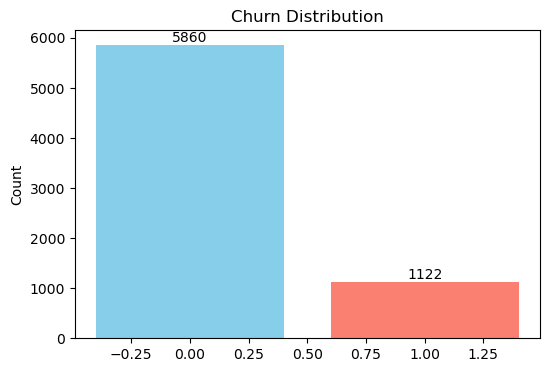

In [15]:
counts = y.value_counts().sort_index()
labels = [0, 1]

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(labels, counts.values, color=["skyblue","salmon"])
ax.set_title("Churn Distribution")
ax.set_ylabel("Count")

# Add the counts above each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height),
            ha="center", va="bottom", fontsize=10)

plt.show()
# save_fig(fig, figures_dir, "01_churn_distribution_colored")

### Customer Age Distribution

Creating a histogram with 20 bins to show how customers are spread across different ages.

Any missing values are dropped to avoid errors, and then plot the counts of customers on the y-axis against their ages on the x-axis.

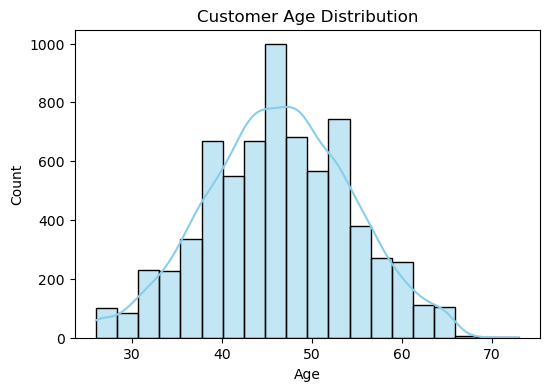

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(X["customer_age"], bins=20, kde=True, color="skyblue")
plt.title("Customer Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

### Gender vs Churn

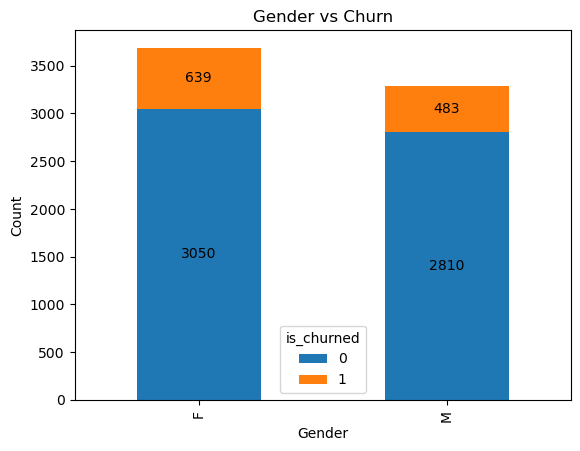

In [17]:
if "gender_M" in df_clean_encoded.columns:
    # Recreate Gender column (assumes binary M/F)
    gender_series = np.where(df_clean_encoded["gender_M"] == 1, "M", "F")
    ct = pd.crosstab(gender_series, df_clean_encoded["is_churned"])

    fig, ax = plt.subplots()
    bars = ct.plot(kind="bar", stacked=True, ax=ax, legend=True)

    ax.set_title("Gender vs Churn")
    ax.set_xlabel("Gender")
    ax.set_ylabel("Count")

    # Add the exact numbers on each stacked segment
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

    plt.show()
    # save_fig(fig, figures_dir, "03_gender_vs_churn_numbers")

### Correlation with Churn

It calculates the correlation of each numeric feature with the target `Churn` and displays them in a horizontal bar chart, highlighting which variables are most linked to customer attrition.

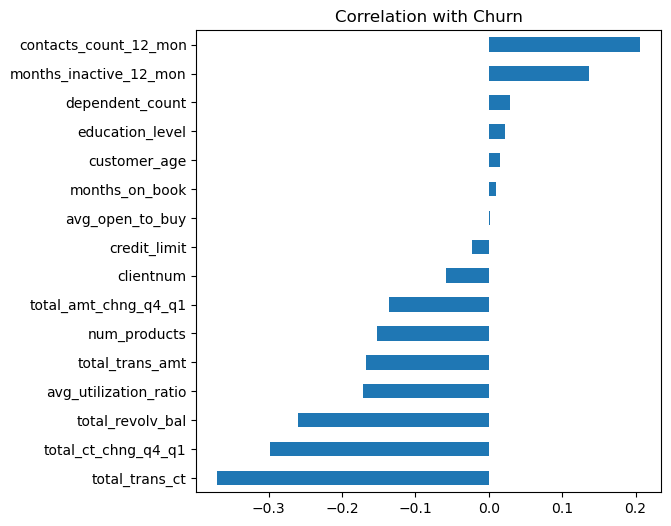

In [18]:
num_df = df_clean_encoded.select_dtypes(include=[np.number])
if "is_churned" in num_df.columns:
    corr_with_target = num_df.corr()["is_churned"].drop("is_churned").sort_values()
    fig, ax = plt.subplots(figsize=(6,6))
    corr_with_target.plot(kind="barh", ax=ax)
    ax.set_title("Correlation with Churn")
    plt.show()
    # save_fig(fig, figures_dir, "05_corr_with_churn")